In [19]:
# importing required packages
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from keras.utils.vis_utils import plot_model
from IPython import display
import pandas as pd

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data.txt",header=None)
index = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/index.txt",header=None)
data = data.to_numpy()
index = index.to_numpy()

In [22]:
print(data.shape)
print(index.shape)
train_dataset = np.reshape(data,(-1,720,16,1))
print(train_dataset.shape)



(2246400, 16)
(6240, 2)
(3120, 720, 16, 1)


In [23]:
print(train_dataset[2].shape)
train_imgs = train_dataset

(720, 16, 1)


In [24]:
N_Imag = 3120
Batch_Size = 12
noise_d = 200
train_set = tf.data.Dataset.from_tensor_slices(train_imgs).shuffle(N_Imag).batch(Batch_Size)

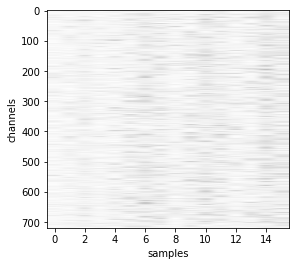

In [25]:
# Architecture for Generator

def generator_model():
    model = tf.keras.Sequential()
    # First Layer (from noise 100x1 to 7*7*256)
    model.add(layers.Dense(4*180*64, use_bias=False, input_shape=(noise_d,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((180, 4, 64)))
    assert model.output_shape == (None, 180, 4, 64) 

    # Second Layer (1st Deconvolution)
    model.add(layers.Conv2DTranspose(128, (10,2), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 180, 4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # Thirds Layer (2nd Deconvolution)
    model.add(layers.Conv2DTranspose(64, (10,2), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 360, 8, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (10,2), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 720, 16, 1)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Forth Layer (3rd Deconvolution)
    #model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    #assert model.output_shape == (None, 16, 720, 1)

    return model

G = generator_model()
# Making Noise !!
noise = tf.random.normal([1, noise_d])
# Feeding the noise to the generator
generated_img = G(noise, training=False)
# Plotting the (not-so-fancy) output 
#plt.imshow(generated_img[0,:,:,0], cmap='gray')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(np.abs(generated_img[0,:,:,0]),cmap='Greys')
plt.xlabel('samples')
plt.ylabel('channels')
ax.set_aspect(0.02)

In [26]:
G.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 46080)             9216000   
_________________________________________________________________
batch_normalization_8 (Batch (None, 46080)             184320    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 46080)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 180, 4, 64)        0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 180, 4, 128)       163840    
_________________________________________________________________
batch_normalization_9 (Batch (None, 180, 4, 128)       512       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 180, 4, 128)      

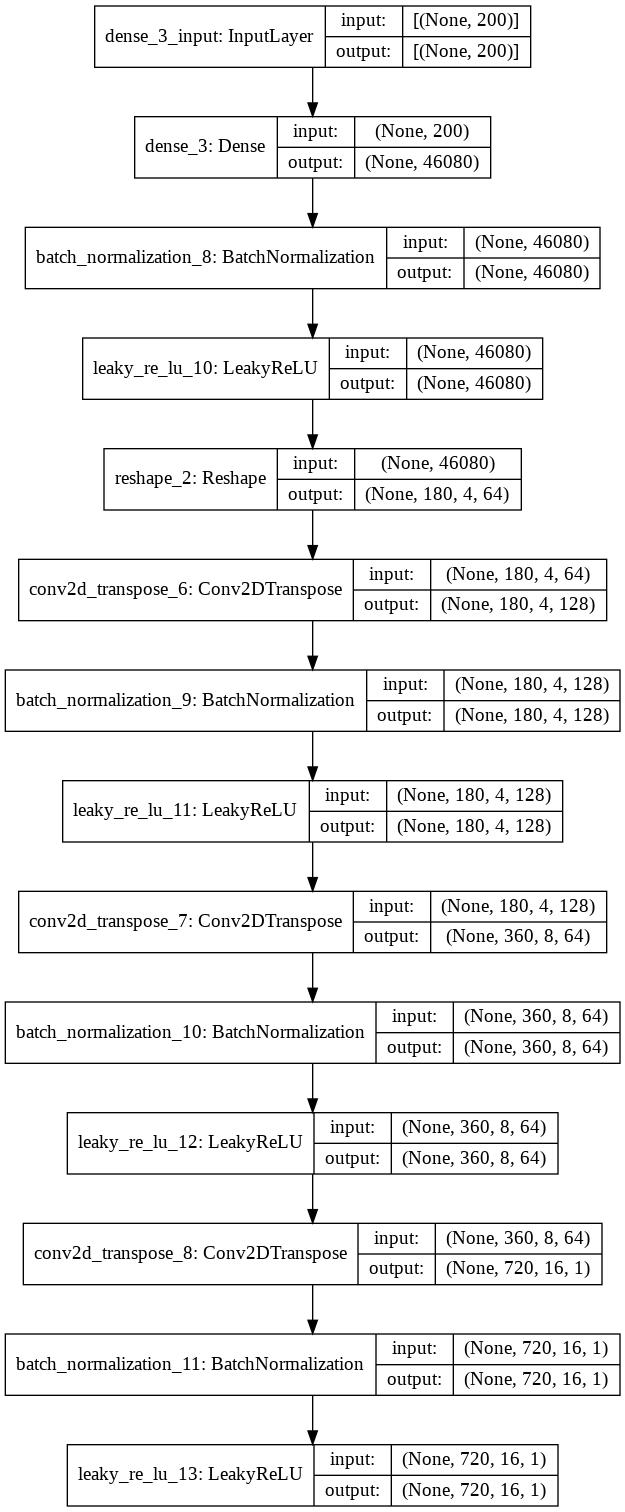

In [27]:
plot_model(G, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [28]:
def discriminator_model():
    model = tf.keras.Sequential()
    # First 2D Conv Layer
    model.add(layers.Conv2D(64, (20,4), strides=(2,2), padding='same', input_shape=[720,16,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # Second 2D Conv Layer
    model.add(layers.Conv2D(128,(20,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # Flatten the output of the second layer
    model.add(layers.Flatten())
    # Dense layer for scalar output
    model.add(layers.Dense(1))

    return model

D = discriminator_model()

In [29]:
D.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 360, 8, 64)        5184      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 360, 8, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 360, 8, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 4, 128)       655488    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 180, 4, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 180, 4, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 92160)            

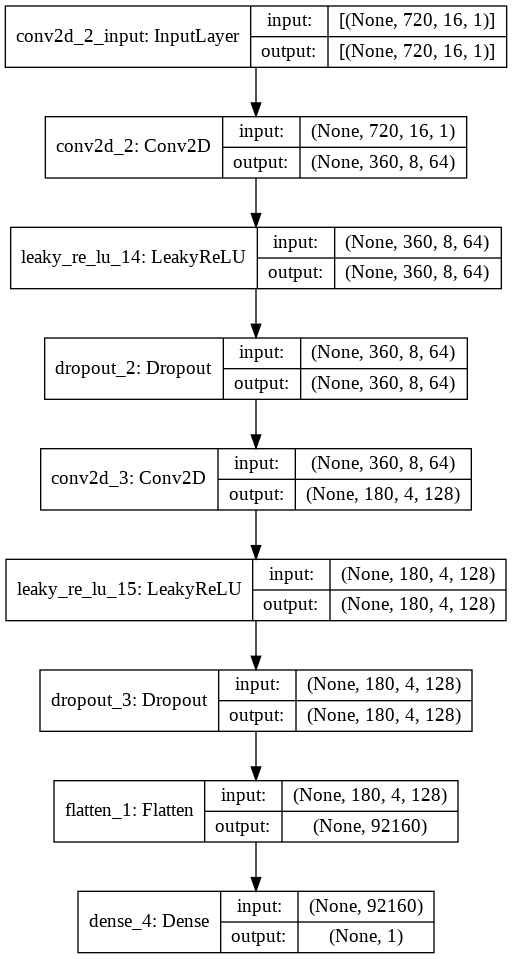

In [30]:
plot_model(D, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [31]:
# Defining Binary-Cross-Entropy loss function instance 
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Discriminator Loss Function
def discriminator_loss(true_output, fake_output):
    T = cross_entropy(tf.ones_like(true_output), true_output)
    F = cross_entropy(tf.zeros_like(fake_output), fake_output)
    D_loss = F + T
    return D_loss
# Generator Loss Function
def generator_loss(fake_output):
    F = cross_entropy(tf.ones_like(fake_output), fake_output)
    return F

In [32]:
Epochs = 500
G_Opt = tf.keras.optimizers.Adam(1e-3)
D_Opt = tf.keras.optimizers.Adam(1e-3)

In [33]:
@tf.function
def train_step(images):
    noise = tf.random.normal([Batch_Size, noise_d])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Making a Noise generated image through the Generator
        generated_img = G(noise, training=True) 
        # True and Fake outputs from Discriminator
        T_out = D(images, training=True)
        F_out = D(generated_img, training=True)
        # Generator Loss
        G_Loss = generator_loss(F_out)
        # Discriminator Loss
        D_Loss = discriminator_loss(T_out, F_out)
    # Gradient Computation
    grad_gen = gen_tape.gradient(G_Loss, G.trainable_variables)
    grad_disc = disc_tape.gradient(D_Loss, D.trainable_variables)
    # Updating the weights
    G_Opt.apply_gradients(zip(grad_gen, G.trainable_variables))
    D_Opt.apply_gradients(zip(grad_disc, D.trainable_variables))
    # Returning the Losses
    return tf.cast(G_Loss, tf.float32),tf.cast(D_Loss, tf.float32)

In [34]:
def train(dataset, epochs):

    G_Loss_History = []
    D_Loss_History = []
    for epoch in range(epochs):
        
        start = time.time()
        G_Losses = []
        D_Losses = []
        for img_batch in dataset:
            G_Loss, D_Loss = train_step(img_batch)
            # Saving the Loss values in an array for the entire dataset
            G_Losses.append(G_Loss)
            D_Losses.append(D_Loss)
            
        # History of all Loss Function Arrays
        G_Loss_History.append(G_Losses)
        D_Loss_History.append(D_Losses)
        G_Mean = sum(G_Losses)/len(G_Losses)
        D_Mean = sum(D_Losses)/len(D_Losses)
        print("Finished training epoch: ", epoch + 1)
        print("Generator Loss : ", G_Mean.numpy() , "Discriminator Loss : ", D_Mean.numpy())


    # Returning Errors
    return G_Loss_History, D_Loss_History

In [35]:
G_Loss_History, D_Loss_History = train(train_set, Epochs)

Finished training epoch:  1
Generator Loss :  1.6121483 Discriminator Loss :  0.44335905
Finished training epoch:  2
Generator Loss :  3.5993533 Discriminator Loss :  0.05738621
Finished training epoch:  3
Generator Loss :  5.763086 Discriminator Loss :  0.01434638
Finished training epoch:  4
Generator Loss :  6.7593336 Discriminator Loss :  0.0048746807
Finished training epoch:  5
Generator Loss :  6.44804 Discriminator Loss :  0.004527218
Finished training epoch:  6
Generator Loss :  6.6942897 Discriminator Loss :  0.0056146234
Finished training epoch:  7
Generator Loss :  7.3626637 Discriminator Loss :  0.008045466
Finished training epoch:  8
Generator Loss :  8.052426 Discriminator Loss :  0.0043338835
Finished training epoch:  9
Generator Loss :  7.8994403 Discriminator Loss :  0.0054976
Finished training epoch:  10
Generator Loss :  8.5623045 Discriminator Loss :  0.0036923245
Finished training epoch:  11
Generator Loss :  8.723273 Discriminator Loss :  0.0005717699
Finished trai

In [36]:
G_Loss = []
D_Loss = []
for i in range(Epochs):
  G_Loss_i = G_Loss_History[i]
  Mean = sum(G_Loss_i)/len(G_Loss_i)
  G_Loss.append(Mean.numpy())
  D_Loss_i = D_Loss_History[i]
  Mean = sum(D_Loss_i)/len(D_Loss_i)
  D_Loss.append(Mean.numpy())

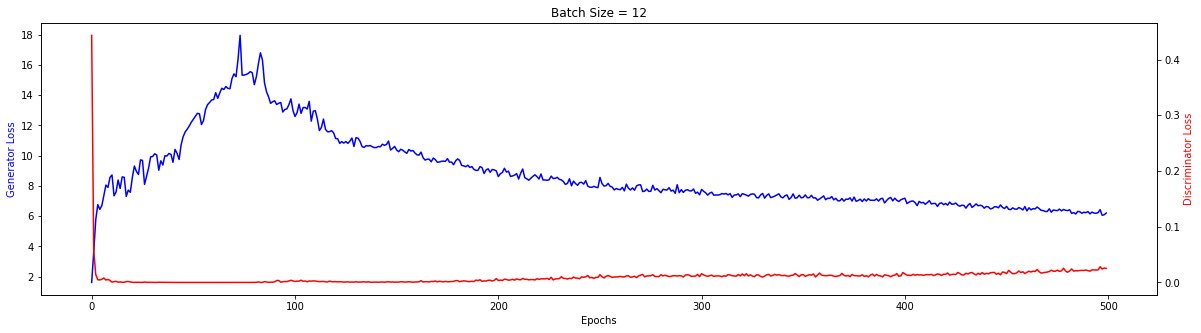

In [37]:
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(G_Loss, 'b-')
ax1.set_ylabel('Generator Loss', color='b')
ax1.set_xlabel('Epochs',color='k')
ax2 = ax1.twinx()
ax2.plot(D_Loss, 'r-')
ax2.set_ylabel('Discriminator Loss', color='r')
plt.title('Batch Size = 12')
plt.show()

In [41]:
seed = tf.random.normal([1, noise_d])

In [42]:
predictions = G(seed, training=False)
predictions = predictions.numpy()
predictions = np.reshape(predictions,(16,720))
print(predictions.shape)

(16, 720)


In [43]:
df = pd.DataFrame(data=predictions)
df.to_csv("./GAN1_out_adam_10_5.csv", sep=',',index=False)